In [6]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import pyproj 
from tqdm import tqdm

from shapely.geometry import Point
from shapely.geometry import LineString

from preprocessing.pre_process_stations import *
#from features.config import * 
#from features.financials import * 
#from features.question_1 import *
#from features.question_2 import *

In [7]:
import warnings

warnings.filterwarnings("ignore")

In [8]:
class Config:
    PATH = '../../data/'

class Params:
    PARAM = 0
config = Config()
p = Params()

## Load data

In [25]:
##### Load and preprocess station data 

df_stations = pd.read_csv(config.PATH+'I-Données de stations TE_DV.xlsx - export_data_te.csv')
df_stations = create_coordinate_column_station(df_stations)
df_stations = transform_station_coordinates(df_stations)

## Full station dataset

In [27]:
### NEEDED TO RUN 
df_stations_full = pd.read_csv(config.PATH+'I-Données_de_stations_improved.csv')
df_stations = clean_stations(df_stations_full)
df_stations = create_coordinate_column_station(df_stations)

df_stations = transform_station_coordinates(df_stations)
#filter out stations to far away from roads 
df_stations_filtered = filter_stations(df_stations) 


In [28]:
df_stations_filtered.shape

(743, 40)

## Exploration


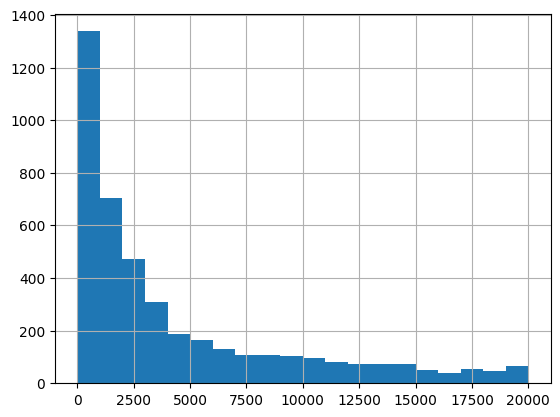

(855, 38)

In [74]:
df_stations[df_stations['distance_to_closest_road']<=20000]['distance_to_closest_road'].hist(bins=20)
plt.show()

df_stations[df_stations['distance_to_closest_road']<=500].shape


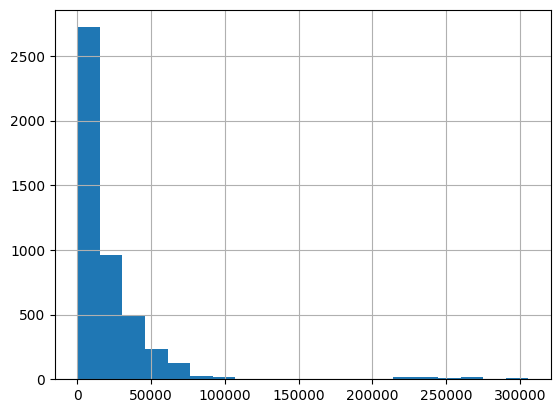

(2259, 38)

In [75]:
df_stations['distance_to_closest_dense_hub'].hist(bins=20)
plt.show()

df_stations[df_stations['distance_to_closest_dense_hub']<=10000].shape

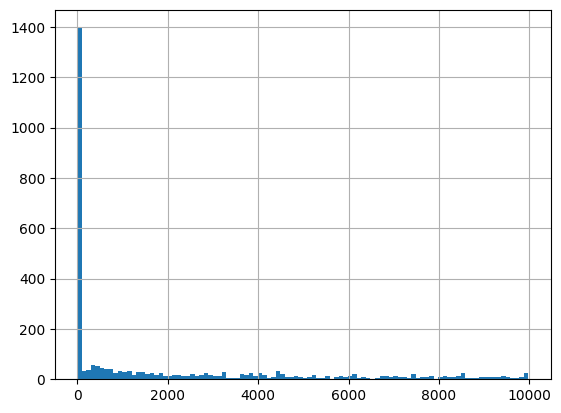

(1313, 38)

In [57]:
df_stations[df_stations['distance_to_closest_large_hub']<=10000]['distance_to_closest_large_hub'].hist(bins=100)
plt.show()

df_stations[df_stations['distance_to_closest_large_hub']<=0].shape

## Load other data

In [43]:
##### Load hub data 
df_hub = gpd.read_file(config.PATH+'F-aire-logistiques-donnees-detaillees/Aires_logistiques_denses.shp')

In [5]:
##### Load traffic data
df_traffic = gpd.read_file(config.PATH+'E-tmja2019-shp/TMJA2019.shp')

## Create distance columns

### Distance to closer station

In [6]:
### THIS ONE WORKS because coordinates of stations in same projection (in meters)

def station_distances(
        df_stations: pd.DataFrame
):
    '''
    Input:
    - df_stations: dataframe of stations with 'Point_coordinate' column in pseudo Lambert-93 projection

    Returns: 
    df_stations dataframe with the new columns:
    - Distance_closer_station: distance to closest other station for each station (using the distance geopandas function)
    - Closer_station_by_index: the index of the closest station (can check its id later)

    The geopandas distance function computes the shortest distance between Point and Point
    '''

    nb_stations = df_stations.shape[0]
    df_stations['Point_coordinate'] = df_stations['Coordinate_transform'].apply(lambda x: Point(x))
    df_stations['Distance_closer_station'] = np.zeros(nb_stations)
    df_stations['Closer_station'] = np.zeros(nb_stations)
    for j in tqdm(range(nb_stations)):
        distance_point_point = []
        for i in range(nb_stations):
            if i != j:
                point = df_stations.loc[i,'Point_coordinate']
                distance_point_point.append(df_stations.loc[j,'Point_coordinate'].distance(point))
            # exclude the distance to its own station
            else:
                distance_point_point.append(1e10)
        df_stations.loc[j,'Distance_closer_station'] = np.min(np.array(distance_point_point))
        df_stations.loc[j,'Closer_station_by_index'] = np.argmin(np.array(distance_point_point))

    return df_stations

In [140]:
#df_stations = create_coordinate_column_station(df_stations)
#df_stations = transform_station_coordinates(df_stations)
df_stations = station_distances(df_stations)

100%|██████████| 4680/4680 [13:10<00:00,  5.92it/s]


In [ ]:
df_stations['Closer_station_by_index'].value_counts

<bound method IndexOpsMixin.value_counts of 0       3569.0
1        623.0
2        285.0
3       3375.0
4         47.0
         ...  
3723    3720.0
3724    3327.0
3725    3495.0
3726    1438.0
3727    2525.0
Name: Closer_station_by_index, Length: 3728, dtype: float64>

### Distance to closer route

In [64]:
### TO DO: GUS
# make sure the stations coordinates and the routes' AND hubs' geometry column are in the same projection
# transform the distances in projection Lambert-93 into KILOMETERS

def compute_route_hub_distance(
        df_stations: pd.DataFrame,
        df_geometry:  pd.DataFrame,
        route: bool
        ):
    
    '''
    Input:
    - df_stations: dataframe of stations 
    - df_geometry: dataframe with 'geometry' column which is a geopandas object 
                   Polygon for hub, Linestring or Multistring for routes

    Returns: 
    df_stations dataframe with the new columns:
    - Distance_closer_route: distance to closest route for each station (using the distance geopandas function)
    - Closer_route_by_index: the index of the closest route (can check its id later)

    The geopandas distance function computes the shortest distance between point and Linestring, Polygon, etc.
    '''

    nb_stations = df_stations.shape[0]
    if route:
        distance_column_name = 'Distance_closer_route'
        route_column_name = 'Closer_route_by_index'
    else:
        distance_column_name = 'Distance_closer_hub'
        route_column_name = 'Closer_hub_by_index'

    df_stations['Point_coordinate'] = df_stations['Coordinate_transform'].apply(lambda x: Point(x))
    df_stations[distance_column_name] = np.zeros(nb_stations)
    df_stations[route_column_name] = np.zeros(nb_stations)

    for j in tqdm(range(nb_stations)):
        distance_point_line = []
        for i in range(df_geometry.shape[0]):
            route = df_geometry.loc[i,'geometry']
            distance_point_line.append(df_stations.loc[j,'Point_coordinate'].distance(route))
        df_stations.loc[j,distance_column_name] = min(distance_point_line)
        df_stations.loc[j,route_column_name] = np.argmin(np.array(distance_point_line))

    return df_stations

In [65]:
# For routes 
df_stations = compute_route_hub_distance(df_stations,df_traffic,route=True)
df_stations['Closer_route_by_index'].value_counts()

  1%|          | 26/3728 [00:08<19:53,  3.10it/s]


KeyboardInterrupt: 

In [ ]:
# For hubs 
df_stations = compute_route_hub_distance(df_stations,df_hub,route=False)
df_stations['Closer_hub_by_index'].value_counts()

100%|██████████| 3728/3728 [01:10<00:00, 52.98it/s]


24.0     3657
236.0      70
295.0       1
Name: Closer_hub_by_index, dtype: int64

In [ ]:
X = np.zeros(df_stations.shape[0])
X[5:6] = 2

In [ ]:
df_stations[X!=0]

,index,URL,Station de service,Ville,Adresse,Coordinates,Energies,Lavage,Paiement,Produits & Services,...,Longitude,Coordinate_transform,Point_coordinate,Distance_closer_station,Closer_station,Closer_station_by_index,Distance_closer_route,Closer_route_by_index,Distance_closer_hub,Closer_hub_by_index
5,5,https://store.totalenergies.fr/fr_FR/NF040353,REL. CRETEIL A86,CRETEIL,"A86 CARREFOUR POMPADOUR , 94000 CRETEIL, FRANCE","48.7776314,2.4408508","AdBlue Truck, Excellium Diesel, Excellium 98, ...",NaN,"Mobility de TotalEnergies, MOL, DKV, Eurotrafi...","AdBlue Truck,",...,2.4408508,"(6944285.41426632, 3119376.7334684525)",POINT (6944285.41426632 3119376.733468452),483.221138,0.0,67.0,6.689395e+06,322.0,6.710509e+06,24.0


### Quantity sold per day

In [ ]:
### Data of operations from slides 

df_g = pd.read_csv(config.PATH+'G-operation-of-stations.csv')
df_g.columns = ['KPI','unit', 1, 2, 4]
df_g.head()

,Unnamed: 0,Unnamed: 1,Small - 1 tpd,Medium - 2 tpd,Large - 4 tpd
0,Capex (installed equipment),m€,3,5,8
1,Depreciation,y,15,15,15
2,Yearly Opex,% of Capex,10,8,7
3,Storage Onsite,tH2,2,3,4
4,Construction time,y,1,1,1


In [ ]:
df_stations['Quantity_sold_per_day(in kg)'] = np.zeros(df_stations.shape[0])

### TO DO 

# Estimation of number of trucks passing per station 
# HOW ? same model as region but per route and then per station

# Transform number of trucks into quantity of H2 sold based on:
# reservoir size (based on brands)
# revervoir persentage filled --> take ... % of reservoir size 

## Create other columns

### Capacity 

In [ ]:
df_stations['Capacity_1'] = df_stations['Quantity_sold_per_day(in kg)']/1000
df_stations['Capacity_2'] = df_stations['Quantity_sold_per_day(in kg)']/2000
df_stations['Capacity_3'] = df_stations['Quantity_sold_per_day(in kg)']/4000

### Profitability

In [10]:
## based on revenue and cost: in m euros 
# check online or ask their teams
price_per_kg_h2 = 10 #(euros per kg)

### TO DO : CES 

#df_stations['Profitability_net'] = 3 - df_stations['Quantity_sold_per_day(in kg)']*price_per_kg_h2

In [13]:
def cost_per_size(X):
    cost=np.zeros(X.shape[0])
    for i,x in enumerate(X):
        if x == 1:
            cost[i] = 3000000
        elif x == 2:
            cost[i] = 5000000
        elif x == 3:
            cost[i] = 80000000
        else:
            cost[i] = None
    return cost

In [50]:
x=np.array([1,2,3])
y=np.array([4,2,3])

d = pd.DataFrame(y,x).reset_index()

In [53]:
d

,index,0
0,1,4
1,2,2
2,3,3


In [51]:
x=np.array([1,2,3])
y=np.array([4,5,3])

d2 = pd.DataFrame(y,x).reset_index()

In [54]:
d2

,index,0
0,1,4
1,2,5
2,3,3


In [55]:
d.merge(d2,on='index')

,index,0_x,0_y
0,1,4,4
1,2,2,5
2,3,3,3


## Get results from part 1


In [ ]:
# Calculate the number of H2 Stations needed per region
# for a given distribution of truck brands (percentage of each truck) and a given year 

stations40 = calculate_hydrogen_stations(df_traffic, 0.25, 0.25, 0.5, 2040)
stations40 = stations40.sort_values(by='Hydrogen Stations Needed', ascending = False)
stations40

## Define the optimization problem

In [11]:
stations40 = pd.read_csv(config.PATH+'results_part_1.csv')

In [12]:
stations40['Hydrogen Stations Needed'].sum()

2225

In [13]:
nb_stations = df_stations.shape[0]
max_nb_station = 2225
max_nb_station = 376

In [30]:
import pygad
def fitness(X,data: pd.DataFrame=df_stations_filtered):

    fit = 0
    X = np.array(X)
    data = station_distances(data)
    data = compute_kpi(data,X) # add columns: Capacity, Profitability_by_thr, Profitability_net
    data = data[data['Distance_closer_station'] < 720000*0.8]
    data = data[X!=0]
    
    # constraint 1: number stations == result from part 1
    if sum((X!=0))==max_nb_station:  
        # constraint profitability: make sure the station is profitable 
        profit = data['Profitability_by_thr'].sum()
        if profit > 0:
            fit = data['distance_to_closest_large_hub'] + data['distance_to_closest_large_hub'] - data['Distance_closer_station'] - data['Capacity']
        else: 
            fit = 10e10000
    else:
        fit = 10e10000
        
    return fit

def evaluate_sol(X):
    return fitness(X)

varbound = np.array([[0,3]]*nb_stations) # binary variables for existing stations

ga_instance=pygad.GA(num_generations=100,
                num_parents_mating=10,
                fitness_func=evaluate_sol,
                sol_per_pop=50,
                num_genes=nb_stations,
                gene_type=[int]*nb_stations,
                gene_space=varbound)

# Run the GA
ga_instance.run()
best_solution = ga_instance.best_solution
best_fitness = ga_instance.best_solution_fitness
print("Best solution:", best_solution)
print("Best fitness:", best_fitness)

ValueError: The fitness function must accept 2 parameters:
1) A solution to calculate its fitness value.
2) The solution's index within the population.

The passed fitness function named 'evaluate_sol' accepts 1 parameter(s).

In [ ]:
ga_instance.plot_fitness()

In [ ]:
# parameters to tune 

algorithm_param = {'max_num_iteration': None,\
                   'population_size':100,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

In [32]:
df_stations_filtered = df_stations_filtered.reset_index(drop=True)

In [35]:
df_stations_filtered['Quantity_sold_per_day(in kg)'] = np.zeros(df_stations_filtered.shape[0])

## Deap library

In [9]:
def get_closer_station(
        df_stations: pd.DataFrame
):
    
    columns_distance = [x for x in df_stations.columns if x.startswith('https')==True]
    df_stations['distance_closer_station'] = df_stations[columns_distance].apply(lambda x: min(x[x!=0]), axis=1)


    return df_stations

In [10]:
df_stations = pd.read_csv(config.PATH+'stations_ready_for_optim.csv')

In [76]:
import random
from deap import creator, base, tools, algorithms


# Define the creator for the individual with two columns
creator.create("FitnessMin", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
creator.create("Column1", list, n=376, unique=True)
creator.create("Column2", list, n=376)

# Define the toolbox for the genetic algorithm
toolbox = base.Toolbox()
toolbox.register("column1", random.sample, range(3090), 376)
toolbox.register("column2", random.randint, 1, 3)
toolbox.register("individual", tools.initCycle, creator.Individual, [creator.Column1(n=376), creator.Column2(n=376)])
toolbox.register("population", tools.initRepeat, list, toolbox.individual, n=10)


# Define the fitness function that takes a pandas DataFrame as input and returns a fitness score
def fitness(X,data: pd.DataFrame=df_stations):
    index, sizes = X
    print(sizes)
    
    columns_distance = [c for c in data.columns if c.startswith('https')==True]
    if data[index].shape[0]>0:
        print(data[X!=0].shape)
        columns_distance_drop = [x for i,x in enumerate(columns_distance) if X[i]==0]
        data = get_closer_station(data[index].drop(columns=columns_distance_drop))
        data = compute_kpi(data,index,sizes) # add columns: Capacity
        data = data[data['distance_closer_station'] < 150000*0.8]

        # constraint profitability: make sure the station is profitable 
        profit = data[index]['Profitability_by_thr'].sum()
        
        if profit > 0:
            fit = data_sub[index]['distance_to_closest_large_hub'] + data_sub[index]['distance_to_closest_large_hub'] - data_sub[index]['distance_closer_station'] - 100*data_sub[index]['Capacity'] - 10*data_sub[index]['Revenue']
        else: 
            print('machin')
            fit = 10e10

    else:
        print('youhou')
        fit = 10e10
        
    return fit

def evalOneMax(individual):
    print(len(individual))
    fit = fitness(individual)
    fitness_values.append(fit)
    return fit,

fitness_values = []

toolbox.register("evaluate", evalOneMax) #evaluate_individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

NGEN=5
for gen in tqdm(range(NGEN)):
    offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.1)
    fits = toolbox.map(toolbox.evaluate, offspring)
    
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))
top10 = tools.selBest(population, k=10)

  0%|                                                     | 0/5 [00:00<?, ?it/s]

3089


ValueError: too many values to unpack (expected 2)

In [113]:
import random
import numpy as np
from deap import base, creator, tools

# Define the number of variables and the ranges for each column
n_vars = 376
column1_range = (0, 3089)
column2_range = (0, 3089)

# Define the fitness function that takes a pandas DataFrame as input and returns a fitness score
def fitness_fun(X,data: pd.DataFrame=df_stations):
    index = np.array(np.array(X[:n_vars])[1])
    sizes = np.array(X[n_vars:])
    print(sizes)
    
    columns_distance = [c for c in data.columns if c.startswith('https')==True]
    if data[index].shape[0]>0:
        columns_distance_drop = [x for i,x in enumerate(columns_distance) if X[i]==0]
        data = get_closer_station(data[index].drop(columns=columns_distance_drop))
        data = compute_kpi(data,index,sizes) # add columns: Capacity, Profitability_by_thr, Profitability_net
        data = data[data['distance_closer_station'] < 150000*0.8]

        # constraint profitability: make sure the station is profitable 
        profit = data.iloc[index,:]['Profitability_by_thr'].sum()
        
        if profit > 0:
            fit = data_sub.iloc[index,:]['distance_to_closest_large_hub'] + data_sub.iloc[index,:]['distance_to_closest_large_hub'] - data_sub.iloc[index,:]['distance_closer_station'] - 100*data_sub.iloc[index,:]['Capacity'] - 10*data_sub.iloc[index,:]['Revenue']
        else: 
            print('machin')
            fit = 10e10

    else:
        print('youhou')
        fit = 10e10
        
    return fit,

# Define the fitness function
def eval_fitness(individual):
    return fitness_fun(individual),

# Define the types of the variables in the individual
creator.create("FitnessMin", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()
toolbox.register("column1", random.randint, 1,3)
toolbox.register("column2", random.sample, range(*column2_range), n_vars)
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.column1, toolbox.column2), n=n_vars)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register genetic operators
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
toolbox.register("select", tools.selBest, k=10)

# Set up statistics object
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("mean", np.mean)

# Set up the genetic algorithm
pop = toolbox.population(n=10)
for gen in range(2):
    fitnesses = []
    for ind in pop:
        fitnesses.append(eval_fitness(ind))
        ind.fitness.values = fitnesses[-1]
    top10 = toolbox.select(pop, k=10)
    top10_fitnesses = [eval_fitness(ind) for ind in top10]
    print(f"Generation {gen}: top 10 fitnesses {top10_fitnesses}")
    offspring = [toolbox.clone(ind) for ind in top10]
    for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
        toolbox.mate(ind1, ind2)
        del ind1.fitness.values, ind2.fitness.values
    for ind in offspring:
        toolbox.mutate(ind)
        del ind.fitness.values
    pop[:] = top10 + offspring

# Print the final population and their fitnesses
for i, ind in enumerate(pop):
    print(f"Individual {i}: {ind}, Fitness: {eval_fitness(ind)}")

TypeError: sample() missing 1 required positional argument: 'k'

In [138]:
def compute_kpi(df_stations,index,x):
    x[x==3] = 4
    sizes = pd.DataFrame(index,x).reset_index()   
    df_stations_merged = sizes.merge(df_stations.reset_index(),how='inner',left_on=sizes.columns[1],right_on=df_stations.columns[0])

    df_stations_merged['Capacity'] = df_stations_merged['Quantity_sold_per_day(in kg)']/(x*1000)

    # Profitability threshold is 0.9, 0.8 and 0.6 for stations with 1,2,4 tones of storage respectively
    df_stations_merged['Profitability_by_thr'] = np.zeros(df_stations_merged.shape[0])
    df_stations_merged[df_stations_merged['Capacity'] > (1-x)/10]['Profitability_by_thr'] = 1

    return df_stations_merged

In [153]:
import random
import numpy as np
from deap import base, creator, tools

# Define the fitness function
# Define the fitness function that takes a pandas DataFrame as input and returns a fitness score
def fitness(X,data: pd.DataFrame=df_stations):
    sizes = np.array(X[0])
    index = np.array(X[1])
    
    columns_distance = [c for c in data.columns if c.startswith('https')==True]
    if data.iloc[index,:].shape[0]>0:
        columns_distance_drop = [columns_distance[i] for i in index]
        data = get_closer_station(data.iloc[index,:].drop(columns=columns_distance_drop))
        data_sub = compute_kpi(data,index,sizes) # add columns: Capacity, Profitability_by_thr, Profitability_net
        data_sub = data_sub[data_sub['distance_closer_station'] < 150000*0.8]
        # constraint profitability: make sure the station is profitable 
        profit = data_sub['Profitability_by_thr'].sum()
        print(profit)
        if profit >= 0:
            fit = (data_sub['distance_to_closest_large_hub'] + data_sub['distance_to_closest_large_hub'] - data_sub['distance_closer_station'])/100 - 1000*data_sub['Capacity'] - data_sub['Revenues']
        else: 
            print('machin')
            fit = 10e10

    else:
        print('youhou')
        fit = 10e10
        
    return fit,

# Define the creation of individuals
def create_individual():
    column1 = [random.randint(0, 3) for _ in range(376)]
    column2 = random.sample(range(3089), 376)
    return column1, column2

# Define the evaluation function
def evaluate(individual):
    return fitness(individual),

# Set up the DEAP toolbox
creator.create("FitnessMin", base.Fitness, weights=(1.0,))
creator.create("Individual", tuple, fitness=creator.FitnessMin)
toolbox = base.Toolbox()

# Register the genetic operators
toolbox.register("individual", create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=3, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Set the number of generations and the population size
num_generations = 2
population_size = 10

# Create the initial population
population = toolbox.population(n=population_size)

# Evaluate the initial population
fitnesses = list(map(toolbox.evaluate, population))
for ind, fit in zip(population, fitnesses):        
    ind.fitness.values = fit

# Set up the hall of fame and statistics objects
hof = tools.HallOfFame(10)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("max", np.max)
stats.register("min", np.min)

# Start the evolution process
for generation in range(num_generations):
    # Select the next generation individuals
    offspring = toolbox.select(population, len(population))

    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        toolbox.mate(child1, child2)
        del child1.fitness.values
        del child2.fitness.values

    for mutant in offspring:
        toolbox.mutate(mutant)
        del mutant.fitness.values

    # Evaluate the new individuals
    fresh_individuals = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, fresh_individuals)
    for ind, fit in zip(fresh_individuals, fitnesses):
        print(ind)
        ind.fitness.values = fit

    # Add the new individuals to the population
    population[:] = offspring

    # Update the hall of fame and statistics
    hof.update(population)
    record = stats.compile(population)
    print("Generation {}:".format(generation + 1))
    print("  Min fitness value:", record["min"][0])
    print("  Max fitness value:", record["max"][0])
    print("  Avg fitness value:", record["avg"])
    print("  Top 10 solutions:", hof.items)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


AttributeError: 'list' object has no attribute 'fitness'

In [298]:
def compute_kpi_bis(df_stations,index):
    x = np.random.randint(1,3,index.shape[0])
    x[x==3] = 4
    sizes = pd.DataFrame(index,x).reset_index()  
    df_stations_merged = sizes.merge(df_stations.reset_index(),how='inner',left_on=sizes.columns[1],right_on=df_stations.columns[0])
    df_stations_merged = df_stations_merged.iloc[:376,:]
    df_stations_merged['Capacity'] = df_stations_merged['Quantity_sold_per_day(in kg)']/(x*1000)

    # Profitability threshold is 0.9, 0.8 and 0.6 for stations with 1,2,4 tones of storage respectively
    df_stations_merged['Profitability_by_thr'] = np.zeros(df_stations_merged.shape[0])
    df_stations_merged[df_stations_merged['Capacity'] > (1-x)/10]['Profitability_by_thr'] = 1

    return df_stations_merged

In [425]:
import random
import numpy as np
from deap import base, creator, tools

# Define the fitness function
# Define the fitness function that takes a pandas DataFrame as input and returns a fitness score
def fitness(X,data: pd.DataFrame=df_stations):
    index = X[0]

    if type(index)==int:
        print('error')
        index = np.random.choice(list(range(3089)), size=376, replace=False)

    columns_distance = [c for c in data.columns if c.startswith('https')==True]
    if data.iloc[index,:].shape[0]>0:
        columns_distance_drop = [columns_distance[i] for i in index]
        data_sub = get_closer_station(data.iloc[index,:].drop(columns=columns_distance_drop))
        data_sub = compute_kpi_bis(data_sub,index) # add columns: Capacity, Profitability_by_thr, Profitability_net
        data_sub = data_sub[data_sub['distance_closer_station'] < 150000*0.8]
        # constraint profitability: make sure the station is profitable 
        profit = data_sub['Profitability_by_thr'].sum()
        if profit >= 0:
            fit = (data_sub['distance_to_closest_large_hub'].mean() + data_sub['distance_to_closest_dense_hub'].mean() - data_sub['distance_closer_station'].mean())/100 - 100*data_sub['Capacity'].mean() - data_sub['Revenues'].mean()
        else: 
            fit = 10e10

    else:
        fit = 10e10
        
    return fit

# Define the evaluation function
def evaluate(individual):
    return fitness(individual),

# Set up the DEAP toolbox
creator.create("FitnessMin", base.Fitness, weights=[1.0,])
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()

# Register the genetic operators
toolbox.register("individual", tools.initRepeat, creator.Individual, lambda: np.random.choice(list(range(3089)), size=376, replace=False),n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=3, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Set the number of generations and the population size
num_generations = 50
population_size = 50

# Create the initial population
population = toolbox.population(n=population_size)

# Evaluate the initial population
fitnesses = list(map(toolbox.evaluate, population))
for ind, fit in zip(population, fitnesses):        
    ind.fitness.values = fit

# Set up the hall of fame and statistics objects
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("max", np.max)
stats.register("min", np.min)
stats.register("argmin", np.argmin)

avg_fitness = []
min_fitness = []
max_fitness = []
arg_min_fitness = []

# Start the evolution process
for generation in range(num_generations):
    
    population = [x for x in population if type(x)!=int]
    print(len(population))

    # Select the next generation individuals
    offspring = toolbox.select(population, len(population))

    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if len(child1[0])==1:
            child1[0] = np.random.choice(list(range(3089)), size=376, replace=False)
        elif len(child1[0])==1:
            child2[0] = np.random.choice(list(range(3089)), size=376, replace=False)
        else:
            toolbox.mate(child1[0], child2[0])
        del child1.fitness.values
        del child2.fitness.values

    for mutant in offspring:
        toolbox.mutate(mutant)
        del mutant.fitness.values

    # Evaluate the new individuals
    fresh_individuals = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, fresh_individuals)
    for ind, fit in zip(fresh_individuals, fitnesses):
        ind.fitness.values = fit

    # Add the new individuals to the population
    population[:] = offspring

    # Update the hall of fame and statistics
    #hof.update(population)
    record = stats.compile(population)
    print("Generation {}:".format(generation + 1))
    avg_fitness.append(record["avg"])
    min_fitness.append(record["min"])
    max_fitness.append(record["max"])
    arg_min_fitness.append(record["argmin"])
    
    #populations.append(arg_min_fitness+population)
    #print("  Top 10 solutions:", hof.items)

50
error
Generation 1:
50
error
error
Generation 2:
50
error
error
Generation 3:
50
Generation 4:
50
error
Generation 5:
50
error
error
Generation 6:
50
error
error
error
Generation 7:
50
error
error
Generation 8:
50
error
Generation 9:
50
error
error
error
error
error
Generation 10:
50
error
error
error
Generation 11:
50
error
error
Generation 12:
50
error
error
error
Generation 13:
50
error
error
Generation 14:
50
error
Generation 15:
50
error
error
Generation 16:
50
error
error
Generation 17:
50
error
error
Generation 18:
50
error
error
Generation 19:
50
error
error
error
error
Generation 20:
50
error
Generation 21:
50
error
Generation 22:
50
error
error
error
Generation 23:
50
error
Generation 24:
50
error
Generation 25:
50
error
error
error
Generation 26:
50
error
error
Generation 27:
50
error
error
error
error
Generation 28:
50
error
error
error
Generation 29:
50
error
error
error
Generation 30:
50
error
error
error
Generation 31:
50
error
error
error
error
error
Generation 32:
5

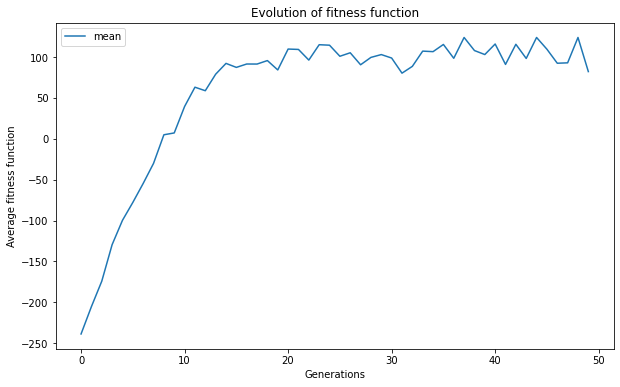

In [433]:
fig = plt.figure(figsize=(10,6))
plt.plot(np.arange(len(avg_fitness)),avg_fitness,label='mean')
# plt.plot(np.arange(len(min_fitness)),min_fitness,label='min')
# plt.plot(np.arange(len(max_fitness)),max_fitness,label='max')
plt.xlabel('Generations')
plt.ylabel('Average fitness function')
plt.legend()
plt.title('Evolution of fitness function')
plt.show()

In [427]:
results = pd.DataFrame(population) # the best individual per generation

In [428]:
results

,0
0,"[625, 1820, 2820, 2110, 2458, 2556, 2018, 2354..."
1,3
2,"[625, 1820, 2820, 2110, 2458, 2556, 2018, 2354..."
3,"[625, 1820, 2820, 2110, 2458, 2556, 2018, 2354..."
4,1
5,"[625, 1820, 2820, 2110, 2458, 2556, 2018, 2354..."
6,"[625, 1820, 2820, 2110, 2458, 2556, 2018, 2354..."
7,"[625, 1820, 2820, 2110, 2458, 2556, 2018, 2354..."
8,"[625, 1820, 2820, 2110, 2458, 2556, 2018, 2354..."
9,"[625, 1820, 2820, 2110, 2458, 2556, 2018, 2354..."


In [429]:
results.to_csv(config.PATH+'results_part_2.csv')

In [431]:
best_gen = np.argmin(min_fitness)
#best_sol = populations[best_gen][arg_min_fitness[best_gen]]

In [432]:
best_gen

39

In [375]:
arg_min_fitness[best_gen]

7

In [403]:
population

[[1],
 [array([1589, 2326, 1667, 1615,  390, 1756, 2255, 1443,  917,  934, 1124,
         1298, 2845,  862,  933, 1763,  179, 2603,  600, 1128,  261, 1007,
          809,  846,  620, 1114, 1245, 2419, 1148, 1629, 1748, 1768, 2250,
         2159,  949, 1166,  187, 2956,  830,  119, 2055, 2111, 1938, 2301,
         2020, 2914, 1714, 1193, 2769,  357,  128, 1614, 1275,  523,   40,
          103, 1549, 1179, 1011, 1867,  935,   75, 3061,  583, 2033, 1504,
         2279, 2010, 1258, 1081,  417,  122, 2382,  963, 2398,  683, 1781,
         2314, 2772, 1720, 2171,  982, 2461, 2735, 1290, 2319, 3053, 1083,
         1643, 1130, 1006, 2295, 1610, 1423,  586, 1921,  877, 1101, 1347,
         2784, 2921,  959, 2321, 2873, 1894, 2477, 1481,  943, 1010, 2028,
         2237, 1214, 1686, 2839, 2745,  561, 1579,  622, 2269, 2671,  673,
         1974, 2537,  804, 3030, 2406,  421, 2436,  844, 1133,  107, 1921,
          251, 1256,  854, 1290,  741,  921, 2968,  617,  591, 2348, 2766,
         1358, 1211

In [22]:
for i in range(10):
    x = np.array(top10[i])
    df_stations['x'+str(i)] = x

In [28]:
df_stations.to_csv(config.PATH+'results_ga.csv')

In [29]:
results_part_1 = pd.read_csv(config.PATH+'results_part_1.csv')

In [31]:
import random
from tqdm import tqdm
from deap import creator, base, tools, algorithms

creator.create("FitnessMin", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

toolbox.register("attr_bool", random.randint, 0, 3)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=df_stations.shape[0])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


# Define the fitness function that takes a pandas DataFrame as input and returns a fitness score
def fitness(X,data1: pd.DataFrame=df_stations,data_nb_stations=results_part_1):
    max_nb_station = 376
    data = data1.copy()
    fit = 0
    X = np.array(X)
    if data[X!=0].shape[0]>0:
        print(data[X!=0].shape)
    data = get_closer_station(data[X!=0])
    data = compute_kpi(data,X[X!=0]) # add columns: Capacity, Profitability_by_thr, Profitability_net
    data = data[data['distance_closer_station'] < 150000*0.8]
        
    for region in data['nom_region'].values:
        fit = 0
        max_nb_station_region = results_part_1[results_part_1['Region']==region]['Hydrogen Stations Needed'].values[0]
        data_sub = data[data['nom_region']==region]

        # constraint 1: number stations == result from part 1
        if sum((X[data['nom_region']==region]X[0]))==max_nb_station_region:  
            # constraint profitability: make sure the station is profitable 
            profit = data[X[0]]['Profitability_by_thr'].sum()
            if profit > 0:
                fit += data_sub[X[0]]['distance_to_closest_large_hub'] + data_sub[X[0]]['distance_to_closest_large_hub'] - data_sub[X[0]]['distance_closer_station'] - data_sub[X[0]]['Capacity']
            else: 
                fit = 10e10000
        else:
            fit = 10e10000
    else:
        fit = 10e10000
        
    return fit

def evalOneMax(individual):
    return fitness(individual),

toolbox.register("evaluate", evalOneMax) #evaluate_individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

population = toolbox.population(n=300)

NGEN=10
for gen in tqdm(range(NGEN)):
    offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.1)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))
top10_reg = tools.selBest(population, k=10)

  0%|                                                    | 0/10 [00:00<?, ?it/s]

(2289, 3115)


  0%|                                                    | 0/10 [00:01<?, ?it/s]


IndexError: boolean index did not match indexed array along dimension 0; dimension is 3089 but corresponding boolean dimension is 2289

In [24]:
len(top10[0])

100

In [ ]:
### NEXT STEPS

# optimisation sur les valeurs des coordonnées des routes qu'on a choisi 
# (pour optimiser sur ces valeurs et non sur les stations existantes)

# fonction qui mesure distance entre deux stations sur reseaux routier (et non a vol d'oiseau)


In [439]:
results_part_2 = pd.read_csv(config.PATH+'results_part_2.csv', index_col="Unnamed: 0")
pd.Series(results_part_2.iloc[39].values[0].replace('[ ', '').replace(']', '').replace('\n', '').replace('   ', ' ').replace('  ', ' ').split(' ')).astype(int)

In [458]:
pd.Series(results_part_2.iloc[39].values[0].replace('[ ', '').replace(']', '').replace('\n', '').replace('   ', ' ').replace('  ', ' ').split(' ')).astype(int)

0       625
1      1820
2      2820
3      2110
4      2458
       ... 
371     211
372     311
373     614
374    1306
375    1483
Length: 376, dtype: int64

In [ ]:
for 